# Extração

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE

In [2]:
url = 'https://raw.githubusercontent.com/emilibohrer/telecom-x/main/TelecomX_Dados_Limpos.csv'
df = pd.read_csv(url, sep=',', encoding='utf-8')

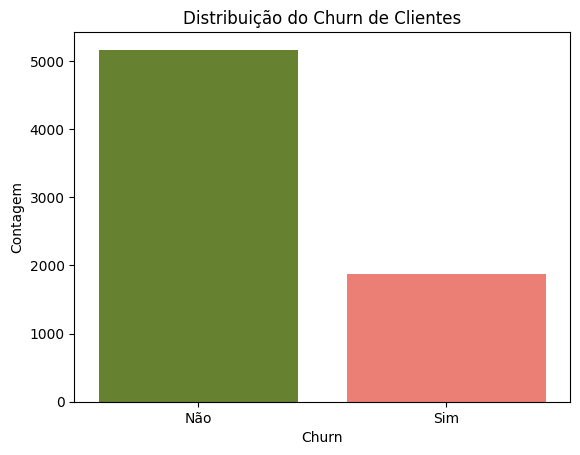

In [3]:
color_dict = {
    1: '#FF6F61',   # vermelho suave
    0: '#6B8E23'    # verde oliva
}

ax = sns.countplot(x='churn', hue='churn', data=df, palette=color_dict, legend=False)

ax.set_title('Distribuição do Churn de Clientes')
ax.set_xlabel('Churn')
ax.set_ylabel('Contagem')

ax.set_xticks([0, 1]) 
ax.set_xticklabels(['Não', 'Sim'])

plt.show()

# Tranformando as variáveis explicativas

In [4]:
df_qtd_valores = df.nunique().to_frame(name='unique_values').sort_values(by='unique_values', ascending=False)
df_qtd_valores[df_qtd_valores['unique_values']<4].index

Index(['protecao_aparelho', 'contrato', 'filmes_streaming', 'tv_streaming',
       'suporte_tecnico', 'backup_online', 'seguranca_online',
       'servico_internet', 'multiplas_linhas', 'genero', 'servico_telefone',
       'fatura_digital', 'dependentes', 'tem_conjuge', 'idoso', 'churn'],
      dtype='object')

In [5]:
x = df.drop('churn', axis = 1)
y = df['churn']

colunas = x.columns

In [6]:
colunas_categoricas = [
    "protecao_aparelho",
    "contrato",
    "filmes_streaming",
    "tv_streaming",
    "suporte_tecnico",
    "backup_online",
    "seguranca_online",
    "servico_internet",
    "multiplas_linhas",
    "genero",
    "servico_telefone",
    "fatura_digital",
    "dependentes",
    "tem_conjuge",
    "idoso",
]

In [7]:
one_hot = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary"),
        colunas_categoricas,
    ),
    remainder="passthrough",
    sparse_threshold=0,
)

In [8]:
one_hot

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['protecao_aparelho', 'contrato',
                                  'filmes_streaming', 'tv_streaming',
                                  'suporte_tecnico', 'backup_online',
                                  'seguranca_online', 'servico_internet',
                                  'multiplas_linhas', 'genero',
                                  'servico_telefone', 'fatura_digital',
                                  'dependentes', 'tem_conjuge', 'idoso'])])

In [9]:
x = one_hot.fit_transform(x)

In [11]:
pd.DataFrame(x, columns = one_hot.get_feature_names_out(colunas))

,onehotencoder__protecao_aparelho_No,onehotencoder__protecao_aparelho_No internet service,onehotencoder__protecao_aparelho_Yes,onehotencoder__contrato_anual,onehotencoder__contrato_bianual,onehotencoder__contrato_mensal,onehotencoder__filmes_streaming_No,onehotencoder__filmes_streaming_No internet service,onehotencoder__filmes_streaming_Yes,onehotencoder__tv_streaming_No,...,onehotencoder__servico_telefone_1,onehotencoder__fatura_digital_1,onehotencoder__dependentes_1,onehotencoder__tem_conjuge_1,onehotencoder__idoso_1,remainder__tempo_de_contrato,remainder__metodo_pagamento,remainder__cobranca_mensal,remainder__cobranca_total,remainder__cobranca_diaria
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,9,Cheque enviado pelo correio,65.6,593.3,2.186667
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,9,Cheque enviado pelo correio,59.9,542.4,1.996667
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,4,Cheque eletronico,73.9,280.85,2.463333
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,13,Cheque eletronico,98.0,1237.85,3.266667
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,3,Cheque enviado pelo correio,83.9,267.4,2.796667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,13,Cheque enviado pelo correio,55.15,742.9,1.838333
7028,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,22,Cheque eletronico,85.1,1873.7,2.836667
7029,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,2,Cheque enviado pelo correio,50.3,92.75,1.676667
7030,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,67,Cheque enviado pelo correio,67.85,4627.65,2.261667


# Transformando a variável alvo